In [1]:
import numpy as np
import pandas as pd

import os

import pydicom as pydi
import cv2

import matplotlib.pyplot as plt

from utils.preprocessing import image_preprocessing

In [3]:
descript_base_dir = "/mnt/data1/OAICompleteData_ASCII/"
image_base = "/mnt/data1/OAI/00m/results/"
mri_file_str = "MRI{mo}.txt"
visit_str = "{0:0=2d}"

In [2]:
def filter_by_view(enrollee_pth, mri_pth, visit_id, view_query="SAG"):
    mri_info = pd.read_csv(mri_pth, sep="|")
    enrollees = pd.read_csv(enrollee_pth)
    
    # Column name formatters
    view_col = "V{id}MEXAMTP".format(id=visit_id)
    date_col = "V{id}MRDATE".format(id=visit_id)
    
    unique_views = [view for view in mri_info[view_col].unique() if view_query in view]
    filtered = mri_info[mri_info[view_col].isin(unique_views)]
    joined_set = enrollees.merge(filtered, on='ID', how='right')
    joined_set[date_col] = pd.to_datetime(joined_set[date_col], infer_datetime_format=True)
    return joined_set

In [4]:
def retrieve_mri(pid, cohort, time, visit_id, mri_barcode):
    slices = []
    mri_pth = "/mnt/data1/OAI/{vid}m/results/{visit}.{cohort}/{pid}/{date}/{barcode}/"
    mri_formatted_pth = mri_pth.format(vid=visit_str.format(visit_id), visit=visit_id, cohort=cohort, pid=pid, 
                                 date=time, barcode=mri_barcode)

    # Preprocessing
    for slice_num in os.listdir(mri_formatted_pth):
        slice_pth = os.path.join(mri_formatted_pth, slice_num)
        img, data, img_before = image_preprocessing(slice_pth)
        slices.append(img)
            
    return slices

In [5]:
filtered = filter_by_view("/home/nlittlefield/Documents/OAI/enrollees.csv", descript_base_dir + "MRI00.txt", "00")

In [7]:
filtered.columns

Index(['Unnamed: 0', 'ID', 'P02HISP', 'P02RACE', 'P02SEX', 'V00CHRTHLF',
       'V00COHORT', 'V00IMAGESC', 'V00IMAGESE', 'V00WOMKPR', 'V00WOMKPL',
       'V01WOMKPR', 'V01WOMKPL', 'V03WOMKPR', 'V03WOMKPL', 'V05WOMKPR',
       'V05WOMKPL', 'V06WOMKPR', 'V06WOMKPL', 'V99ELKBLRP', 'V99ERKBLRP',
       'V99ELKDAYS', 'V99ERKDAYS', 'V99ELKLOA', 'V99ERKLOA', 'V99ELXNOA',
       'V99ERXNOA', 'V99ELKVSAF', 'V99ERKVSAF', 'V00AGE', 'V00XRKLR',
       'V00XRKLL', 'right_joint_is_monotonic', 'left_joint_is_monotonic',
       'right_joint_2_jump', 'left_joint_2_jump', 'left_eligible',
       'right_eligible', 'right_control', 'left_control', 'VERSION',
       'V00MEXAMTP', 'V00MNDREAS', 'V00MRBARCD', 'V00MRCOMP', 'V00MRDATE',
       'V00MRSIDE', 'V00MRSURDY', 'V00MRTECID', 'V00QCRESLT', 'V00SCNUPGR'],
      dtype='object')

In [6]:
samp_patient = filtered.sample(4)

In [7]:
samp_patient

,ID,VERSION_x,P02HISP,P02RACE,P02SEX,V00CHRTHLF,V00COHORT,V00IMAGESA,V00IMAGESB,V00IMAGESC,...,V00MEXAMTP,V00MNDREAS,V00MRBARCD,V00MRCOMP,V00MRDATE,V00MRSIDE,V00MRSURDY,V00MRTECID,V00QCRESLT,V00SCNUPGR
22989,9794242,25,0: No,1: White or Caucasian,2: Female,1: First half of cohort,1: Progression,0: No,0: No,"3: Yes, Knee MR and knee xray",...,R SAG 3D DESS WE,.: Missing Form/Incomplete Workbook,1.661027e+10,1: Yes,2004-10-12,1: Right,NaN,B018,'Y': QCd and found to be acceptable,0: Original OAI Siemens Trio MR used
9906,9379581,25,0: No,2: Black or African American,1: Male,2: Second half of cohort,2: Incidence,0: No,0: No,0: No,...,R SAG 3D DESS WE,.: Missing Form/Incomplete Workbook,1.661094e+10,1: Yes,2005-11-01,1: Right,NaN,A015,'YD': Not QCd and accepted by default,0: Original OAI Siemens Trio MR used
25973,9894048,25,0: No,2: Black or African American,2: Female,2: Second half of cohort,2: Incidence,0: No,0: No,0: No,...,R SAG T2 MAP,.: Missing Form/Incomplete Workbook,1.661109e+10,1: Yes,2006-04-18,1: Right,NaN,A015,'YD': Not QCd and accepted by default,0: Original OAI Siemens Trio MR used
20689,9714958,25,0: No,1: White or Caucasian,1: Male,2: Second half of cohort,2: Incidence,0: No,0: No,0: No,...,L SAG IW TSE FS,.: Missing Form/Incomplete Workbook,1.661065e+10,1: Yes,2006-01-05,2: Left,NaN,B018,'YD': Not QCd and accepted by default,0: Original OAI Siemens Trio MR used


In [8]:
def view_patient_mri(patients, n_slices=4):
    row_counter = 0
    fig, axes = plt.subplots(nrows=len(patients), ncols=n_slices, figsize=(15,15))
        
    for i, row in patients.iterrows():
        cohort = "C.2" if row["V00CHRTHLF"]== "1: First half of cohort" else "E.1" if row["V00CHRTHLF"] == "2: Second half of cohort" else np.nan

        try: date = row["V" + visit_str.format(0) + "MRDATE"].strftime("%Y%m%d")
        except:
            continue

        slices = retrieve_mri(row["ID"], cohort, date, 0, str(int(row["V00MRBARCD"]))[3:]) # Remove the 166 at beginning to get id

        for j, img_slice in enumerate(slices):
            if j >= n_slices: # only show n slices per patient
                break
            
            axes[row_counter, j].imshow(img_slice, cmap="gray")
            axes[row_counter, j].title.set_text(row.V00MEXAMTP + "(" + str(j) + ")")
            axes[row_counter, j].set_axis_off()
        row_counter += 1
    
    grid = plt.GridSpec(len(patients), n_slices)
    
    # Add patient ids
    for i, pid in enumerate(patients.ID):
        row = fig.add_subplot(grid[i, 0:n_slices])
        row.set_title(f'Patient Id: {pid}\n', fontweight='semibold')
        row.set_axis_off()
    fig.show()
    

Row Index: 22989
Row Index: 9906
Row Index: 25973
Row Index: 20689


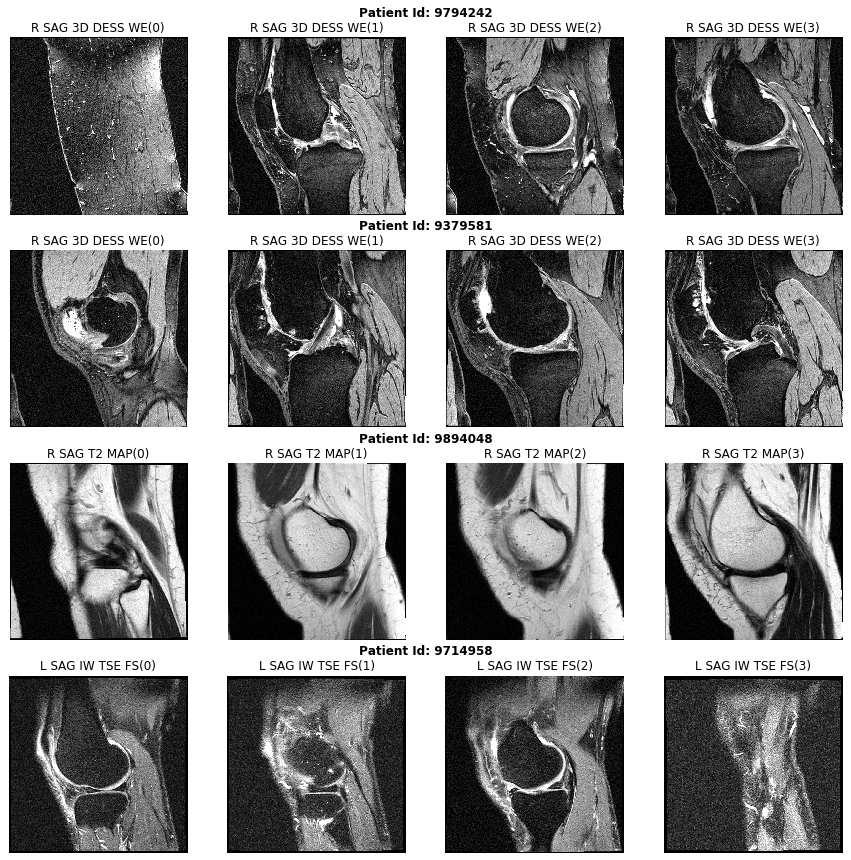

In [9]:
view_patient_mri(samp_patient)